In [2]:
import sys
import os
from skimage.feature import hog
from skimage import feature
from LocalBinaryPattern import LocalBinaryPatterns
import numpy as np
import matplotlib.pyplot as plt
import cv2


import pandas as pd
from skimage.transform import resize
from skimage.io import imread

from sklearn.svm import LinearSVC
from imutils import paths
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import argparse
import cv2
import os
import pickle
# from .._shared.utils import check_nD
# from ._texture import (_glcm_loop,
#                        _local_binary_pattern,
#                        _multiblock_lbp)
np.set_printoptions(threshold=sys.maxsize)

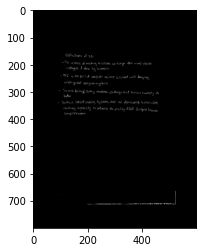

10
----------------------------------------------------------------------------------------------------
[5.35208333e-03 2.23750000e-03 4.08333333e-04 8.95833333e-05
 2.50000000e-05 2.29166667e-05 6.25000000e-06 0.00000000e+00
 2.08333333e-06 2.08333333e-06 2.08333333e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.88858333e-01
 2.99375000e-03]


In [15]:
# with open('img.png', 'w') as f:
    #     f.write(img)
    #     f.close()

infile = open("Test_Data",'rb')
imgs = pickle.load(infile)
infile.close()
plt.imshow(imgs[0], cmap="gray")
plt.show()
print(len(imgs))



In [3]:
def normalize_image(inputImage , standardBackgroundSize , outputImageSize):
    img = inputImage.astype(np.uint8)
    

    max_r, max_c = standardBackgroundSize
    out_r, out_c = outputImageSize
   
    
    #blurred_image = cv2.GaussianBlur(img,(5,5),0)


    threshold, binarized_image = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    cv2.imwrite('D:/third year/2st term/NN/project/M.jpg',binarized_image)
    
    r, c = np.where(binarized_image == 0)

    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())


    cropped = img[r.min(): r.max(), c.min(): c.max()]


    img_r, img_c = cropped.shape

    r_start = max_r // 2 - r_center
    c_start = max_c // 2 - c_center


    if img_r > max_r:
        print ('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_r - max_r
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_r, :]
        img_r = max_r
    else:
        extra_r = (r_start + img_r) - max_r
      
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

   
    if img_c > max_c:
        print ('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_c - max_c
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_c]
        img_c = max_c
    else:
        extra_c = (c_start + img_c) - max_c
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_r, max_c), dtype=np.uint8) * 255
   
    normalized_image[r_start:r_start + img_r, c_start:c_start + img_c] = cropped
    

    normalized_image[normalized_image > threshold] = 0
    
    resized = cv2.resize(normalized_image, (out_r, out_c))
    
    scalled = resized / 255.0
    return scalled

In [4]:
#to  make all same size
i=1
img_resized=[]
outfile = open("Test_Data",'wb')
for imagePath in paths.list_images('D:/third year/2st term/NN/project/dataSet/test' + "/"):
    
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_resized.append(normalize_image(gray,[4000 , 3000],[600,800]))
    
    
    
    
    
pickle.dump(img_resized,outfile)   
outfile.close()

In [62]:
i=1
for imagePath in paths.list_images('D:/third year/2st term/NN/project/dataSet/Male' + "/"):
    print(imagePath)
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_resized = normalize_image(gray,[4000 , 3000],[600,800])
    cv2.imwrite('D:/third year/2st term/NN/project/dataSetSized/Male/M'+str(i)+'.jpg',img_resized)
    i+=1
    print(i)
    break
    

D:/third year/2st term/NN/project/dataSet/Male/M1.jpg
2


In [16]:
def compute_LBP():
    numberOfPoints = 24
    radius = 8
    # initialize the local binary patterns descriptor along with
    # the data and label lists
    desc = LocalBinaryPatterns(numberOfPoints, radius)
    train_data_arr = []
    train_labels_arr = []
    test_data_arr = []
    test_labels_arr = []
    predictions_arr = []


    #train image
    #Initialise labels
    Categories = ['Male_Data', 'Female_Data']
    for i in Categories:
        print(f'loading... category : {i}')
        infile = open(i,'rb')
        imgs = pickle.load(infile)
        infile.close()
        

        for image in imgs:

            
	        # load the image, convert it to grayscale, and describe it
            
            

            
            hist = desc.describe(image)
            train_data_arr.append(hist)
            train_labels_arr.append(Categories.index(i))
            
            # train a Linear SVM on the data
    train_data = np.array(train_data_arr)
    train_label = np.array(train_labels_arr)
    df = pd.DataFrame(train_data)  # dataframe
    df['Target'] = train_label
    x_train = df.iloc[:, :-1]
    y_train = df.iloc[:, -1]  # output data
    param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.1, 1], 'kernel': ['poly', 'linear', 'rbf', 'sigmoid']}
    svc = svm.SVC()
    model = GridSearchCV(svc, param_grid)
    model.fit(x_train, y_train)
    print(model.best_params_)
    print('The Model is trained well with the given images')

    # loop over the valid images
    print("Compute validation")
    Categories = ['Male_Data', 'Female_Data']
    for i in Categories:
        print(f'loading... category : {i}')
        infile = open(i,'rb')
        imgs = pickle.load(infile)
        infile.close()
        

        for image in imgs:

            hist = desc.describe(image)
            test_data_arr.append(hist)
            test_labels_arr.append(Categories.index(i))
    # test_labels_arr=[1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0]
    test_data = np.array(test_data_arr)
    test_label = np.array(test_labels_arr)
    df = pd.DataFrame(test_data)  # dataframe
    df['Target'] = test_label
    x_test = df.iloc[:, :-1]  # input data
    y_test = df.iloc[:, -1]  # output data
    predictions = model.predict(x_test)
    print(f"Accuracy : {accuracy_score(predictions, y_test) * 100}%")
    matrix = confusion_matrix(y_test, predictions)
    print('Confusion matrix : \n', matrix)
    print('Classification report : \n', classification_report(y_test,predictions))

    f = open("result.txt", "w+")
    f.write(f"number of points :{numberOfPoints}\n")
    f.write(f"radius :{radius}\n")
    f.write(f"Accuracy : {accuracy_score(predictions, y_test) * 100}%\n")
    f.write(f"Confusion matrix : {matrix}\n")

    f.close()
    print("now testing")
    infile = open("Test_Data",'rb')
    imgs = pickle.load(infile)
    infile.close()
    print(len(imgs)) 

    for image in imgs:

        hist = desc.describe(image)
        test_data_arr.append(hist)
        test_labels_arr.append(1) 
    test_data = np.array(test_data_arr)
    test_label = np.array(test_labels_arr)
    df = pd.DataFrame(test_data)  # dataframe
    df['Target'] = test_label
    x_test = df.iloc[:, :-1]  # input data
    y_test = df.iloc[:, -1]  # output data
    predictions = model.predict(x_test)  
    print(predictions)  
    print(f"Accuracy : {accuracy_score(predictions, y_test) * 100}%")
   

In [17]:

compute_LBP()

loading... category : Male_Data
loading... category : Female_Data
{'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
The Model is trained well with the given images
Compute validation
loading... category : Male_Data
loading... category : Female_Data
Accuracy : 64.72303206997084%
Confusion matrix : 
 [[222   0]
 [121   0]]
Classification report : 
               precision    recall  f1-score   support

           0       0.65      1.00      0.79       222
           1       0.00      0.00      0.00       121

    accuracy                           0.65       343
   macro avg       0.32      0.50      0.39       343
weighted avg       0.42      0.65      0.51       343

now testing
10


C:\Users\7essen\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\7essen\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\7essen\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy : 62.889518413597735%


True